In [42]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D

## 데이터가져오기

In [32]:
data_dir = './chest_xray/train'
validation_dir = './chest_xray/val'
test_dir = './chest_xray/test'
batch_size = 32
img_height = 180
img_width = 180
IMG_SIZE = (180,180)

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [12]:
class_names = val_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [16]:
class_names = test_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### 데이터셋 시각화

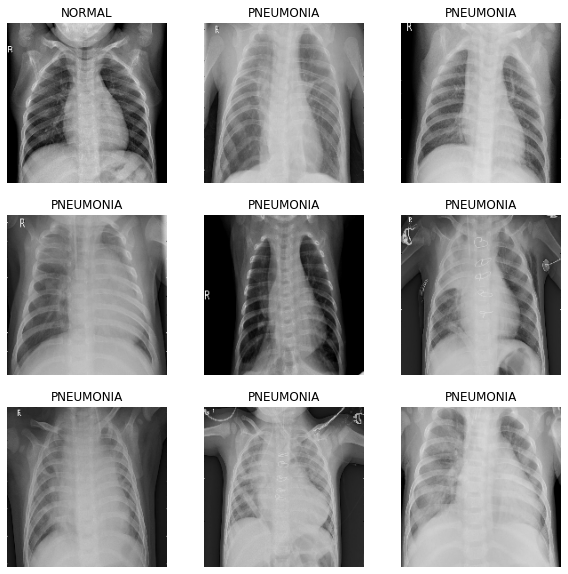

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 프리페치를 사용하여 이미지 로드 속도 상승

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

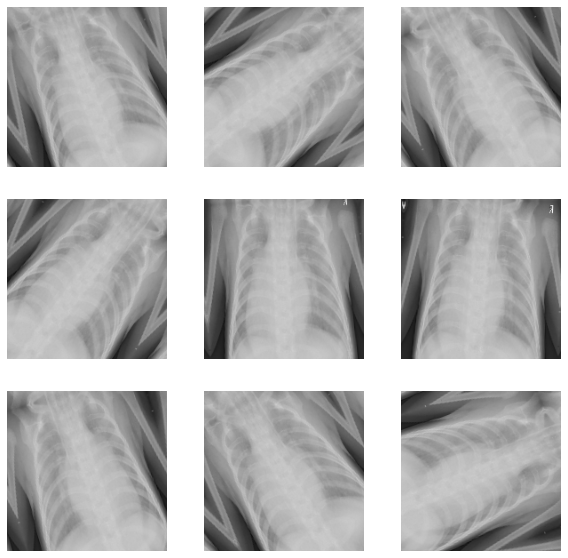

In [28]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [29]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [30]:
# 위방법을 쓰거나 밑에방법으로 픽셀값 조정
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### convolution model 인스턴스화

In [51]:
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(180, 180, 3)))

In [52]:
# 이 특성 추출기는 (180,180,3)이미지를 (5,5,512)개 특징블록으로 변환합니다.

In [53]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


### 특징 추출
convolution model을 동결하고 특징 추출기로 사용합니다. 또한 그 위에 분류기를 추가하고 최상위 분류기를 훈련시킵니다.

In [54]:
base_model.trainable = False

In [55]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### 분류층 추가

In [56]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


### 특성예측을 단일예측으로 변환

In [57]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [59]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0   

In [62]:
len(model.trainable_variables)

2

In [64]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

163/163 [==============================] - 38s 206ms/step - loss: 1.5682 - accuracy: 0.5380


In [65]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.57
initial accuracy: 0.54


In [67]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
163/163 [==============================] - 22s 126ms/step - loss: 1.3245 - accuracy: 0.6210 - val_loss: 0.9529 - val_accuracy: 0.7086
Epoch 2/10
163/163 [==============================] - 21s 125ms/step - loss: 0.9741 - accuracy: 0.6979 - val_loss: 0.6692 - val_accuracy: 0.7757
Epoch 3/10
163/163 [==============================] - 21s 126ms/step - loss: 0.7876 - accuracy: 0.7442 - val_loss: 0.5237 - val_accuracy: 0.8200
Epoch 4/10
163/163 [==============================] - 21s 126ms/step - loss: 0.6530 - accuracy: 0.7753 - val_loss: 0.4206 - val_accuracy: 0.8449
Epoch 5/10
163/163 [==============================] - 21s 126ms/step - loss: 0.5562 - accuracy: 0.8029 - val_loss: 0.3786 - val_accuracy: 0.8622
Epoch 6/10
163/163 [==============================] - 21s 126ms/step - loss: 0.5053 - accuracy: 0.8194 - val_loss: 0.3342 - val_accuracy: 0.8765
Epoch 7/10
163/163 [==============================] - 21s 126ms/step - loss: 0.4783 - accuracy: 0.8299 - val_loss: 0.3113 - val_ac

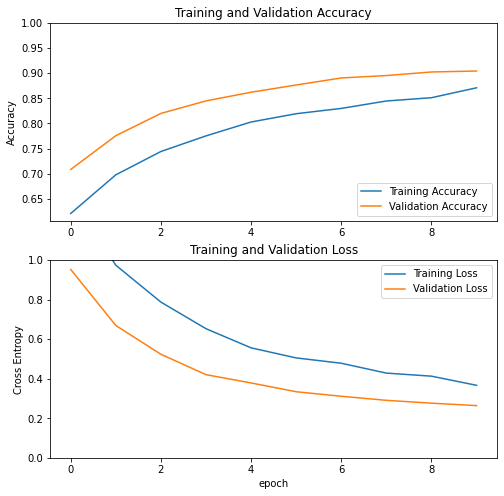

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 최상위 층 고정 해제하기
base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [79]:
base_model.trainable = True

In [80]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [81]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [82]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0   

In [83]:
len(model.trainable_variables)

8

In [85]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
163/163 [==============================] - 25s 139ms/step - loss: 0.2066 - accuracy: 0.9220 - val_loss: 0.1447 - val_accuracy: 0.9392
Epoch 11/20
163/163 [==============================] - 22s 135ms/step - loss: 0.1202 - accuracy: 0.9549 - val_loss: 0.0723 - val_accuracy: 0.9720
Epoch 12/20
163/163 [==============================] - 24s 143ms/step - loss: 0.1023 - accuracy: 0.9630 - val_loss: 0.0821 - val_accuracy: 0.9638
Epoch 13/20
163/163 [==============================] - 23s 137ms/step - loss: 0.0798 - accuracy: 0.9720 - val_loss: 0.0514 - val_accuracy: 0.9785
Epoch 14/20
163/163 [==============================] - 23s 137ms/step - loss: 0.0714 - accuracy: 0.9747 - val_loss: 0.1428 - val_accuracy: 0.9456
Epoch 15/20
163/163 [==============================] - 23s 138ms/step - loss: 0.0607 - accuracy: 0.9760 - val_loss: 0.0799 - val_accuracy: 0.9657
Epoch 16/20
163/163 [==============================] - 23s 137ms/step - loss: 0.0576 - accuracy: 0.9781 - val_loss: 0.0717 -

In [86]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

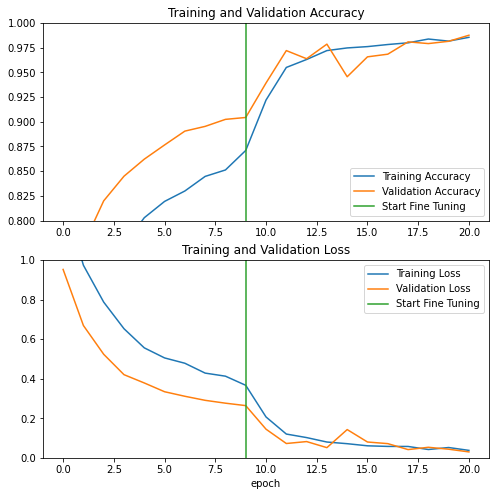

In [87]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [89]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

163/163 [==============================] - 11s 63ms/step - loss: 0.0298 - accuracy: 0.9875
Test accuracy : 0.9875383377075195


Predictions:
 [1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1]
Labels:
 [1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1]


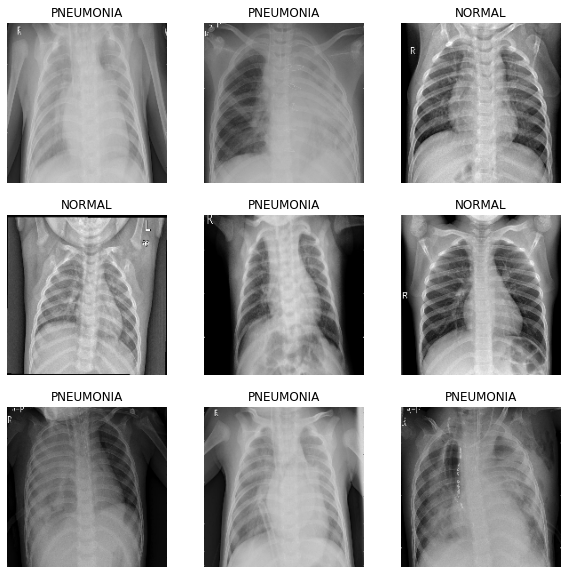

In [91]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")